In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

## Baseline emissions from SSP2 (for scenario 1 and 2)

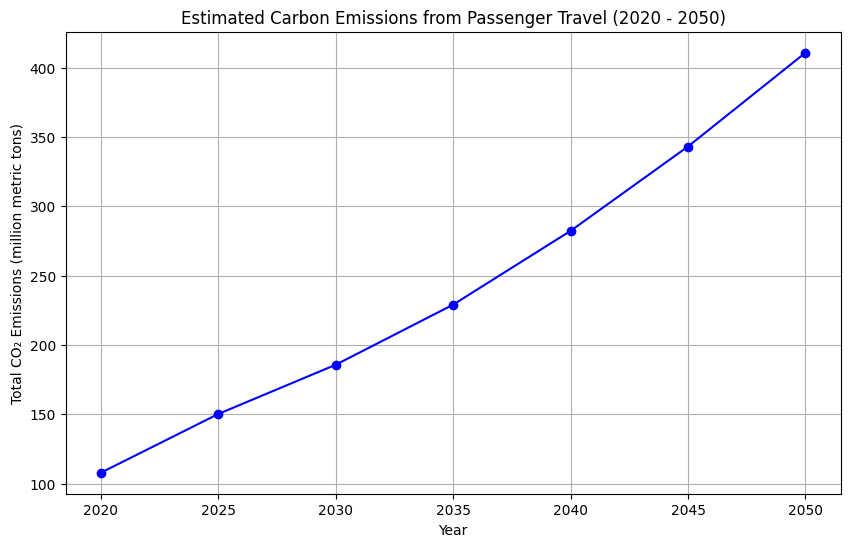

[107.84820620799998, 150.226737848, 185.734964744, 229.08782907599996, 282.306148448, 343.163104796, 410.81356706]


In [6]:
import matplotlib.pyplot as plt

# Given data
passengers = {
    2020: 728704096,  # passengers
    2025: 1015045526,
    2030: 1254965978, 
    2035: 1547890737,
    2040: 1907473976, 
    2045: 2318669627, 
    2050: 2775767345 
}

# Define the emission factor 
kilometers_flown = 1000  # average distance flown per passenger in km
emission_factor = 0.148  # kg CO₂ per passenger per km for Airbus A380 fleet

# Calculate the total emissions for each year (in kg CO2)
emissions_kg = {year: passengers[year] * emission_factor * kilometers_flown for year in passengers}

# Convert emissions to million metric tons of CO2
emissions_million_metric_tons = {year: emissions_kg[year] / 1e9 for year in emissions_kg}

# Plot the results
years = list(emissions_million_metric_tons.keys())
total_emissions = list(emissions_million_metric_tons.values())

plt.figure(figsize=(10, 6))
plt.plot(years, total_emissions, marker='o', linestyle='-', color='b')
plt.title('Estimated Carbon Emissions from Passenger Travel (2020 - 2050)')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions (million metric tons)')
plt.grid(True)
plt.show()

print(total_emissions)


## Scenario 1: Impact of SAF on emissions basline

Completed: 7 steps

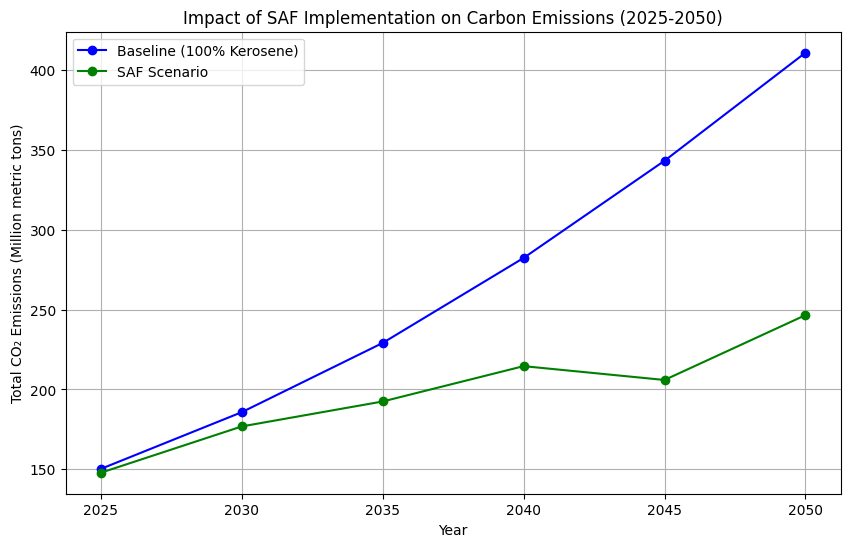

Total Baseline Emissions (2020-2050): 1601.33 Million metric ton CO₂
Total SAF Emissions (2020-2050): 1184.02 Million metric ton CO₂
Reduction in Emissions with SAF by 2050: 417.32 Million metric ton CO₂

Run time: 0:00:00.154282
Simulation finished


In [7]:
# SSP2 passengers data

passengers = {
    2020: 728704096,  
    2025: 1015045526,
    2030: 1254965978,
    2035: 1547890737,
    2040: 1907473976,
    2045: 2318669627,
    2050: 2775767345
}

# Emission factors
emission_factor_kerosene = 0.148  # kg CO₂ per passenger 
kilometers_flown = 1000  # average distance flown per passenger in km
saf_reduction_percentage = 80  # 80% reduction by 2050 with SAF

# SAF implementation rate over time (EU target: 70% by 2050)
saf_implementation = {
    2020: 0.0,
    2025: 2.0,   # % by 2025
    2030: 6.0,   # % by 2030
    2035: 20.0,  # % by 2035
    2040: 30.0,  # % by 2040
    2045: 50.0,  # % by 2045
    2050: 70.0   # % by 2050
}

# Define the Aircraft agent
class Aircraft(ap.Agent):
    def setup(self):
        self.emission_factor_kerosene = emission_factor_kerosene
        self.saf_reduction_percentage = saf_reduction_percentage
    
    def calculate_emissions(self, passengers, saf_fraction):
        # Adjust SAF fraction to account for the maximum blending ratio of 50% (While the goal is to eventually use 100% SAF, as of now, 
        # no SAF has been certified for 100% use in commercial aviation without blending.)
        saf_blended_fraction = min(saf_fraction, 0.5) # (case of Hydroprocessed Esters and Fatty Acids (HEFA))
        kerosene_fraction = 1 - saf_blended_fraction

        # SAF emissions consider the reduced impact
        saf_emissions = passengers * self.emission_factor_kerosene * (saf_blended_fraction * (1 - self.saf_reduction_percentage / 100) + kerosene_fraction) * kilometers_flown / 1e9
        
        return saf_emissions

# Define the model
class SAFModel(ap.Model):
    def setup(self):
        # Create a single aircraft agent
        self.aircraft = Aircraft(self)

        # Store emissions data
        self.emissions_kerosene = {}
        self.emissions_saf = {}

        # Extract years for simulation steps
        self.years = list(passengers.keys())

    def step(self):
        # Ensure the step index is within bounds
        if self.t < len(self.years):
            # Get the current year based on the step index
            year = self.years[self.t]

            # Calculate baseline emissions (all kerosene)
            baseline_emissions = passengers[year] * self.aircraft.emission_factor_kerosene * kilometers_flown / 1e9
            self.emissions_kerosene[year] = baseline_emissions

            # Calculate SAF scenario emissions
            saf_fraction = saf_implementation[year] / 100
            saf_emissions = self.aircraft.calculate_emissions(passengers[year], saf_fraction)
            self.emissions_saf[year] = saf_emissions

    def end(self):
        # At the end of the simulation, plot the results
        years = list(self.emissions_kerosene.keys())
        total_emissions_kerosene = [self.emissions_kerosene[year] for year in years]
        total_emissions_saf = [self.emissions_saf[year] for year in years]
        
        plt.figure(figsize=(10, 6))
        plt.plot(years, total_emissions_kerosene, 'b-o', label='Baseline (100% Kerosene)')
        plt.plot(years, total_emissions_saf, 'g-o', label='SAF Scenario')
        
        plt.title('Impact of SAF Implementation on Carbon Emissions (2025-2050)')
        plt.xlabel('Year')
        plt.ylabel('Total CO₂ Emissions (Million metric tons)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Print total emissions for baseline and SAF scenarios
        total_baseline_emissions = sum(total_emissions_kerosene)
        total_saf_emissions = sum(total_emissions_saf)
        
        print(f"Total Baseline Emissions (2020-2050): {total_baseline_emissions:.2f} Million metric ton CO₂")
        print(f"Total SAF Emissions (2020-2050): {total_saf_emissions:.2f} Million metric ton CO₂")
        print(f"Reduction in Emissions with SAF by 2050: {(total_baseline_emissions - total_saf_emissions):.2f} Million metric ton CO₂")

# Simulation parameters
parameters = {
    'steps': len(passengers)  # Number of years in the simulation
}

# Create and run the model
model = SAFModel(parameters)
results = model.run()


## Scenario 1 without considering the 50% blending

Completed: 7 steps

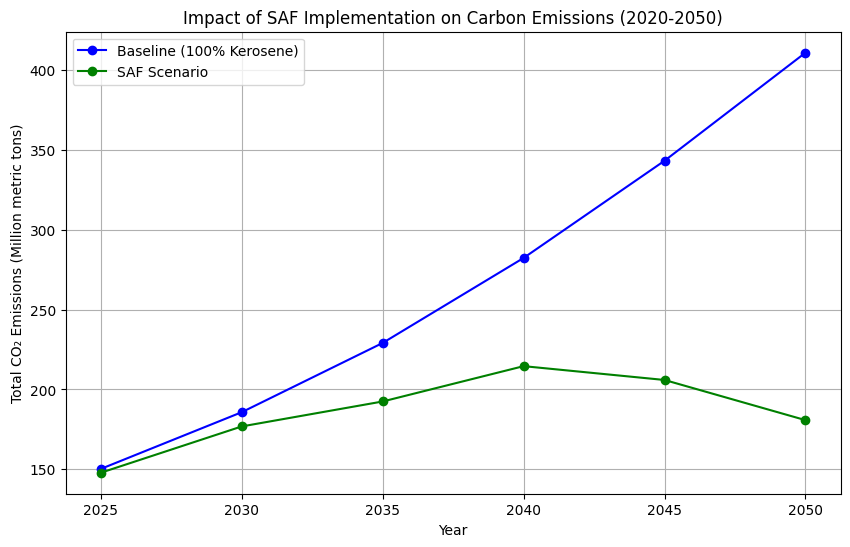

Total Baseline Emissions (2020-2050): 1601.33 Million metric ton CO₂
Total SAF Emissions (2020-2050): 1118.29 Million metric ton CO₂
Reduction in Emissions with SAF by 2050: 483.05 Million metric ton CO₂

Run time: 0:00:00.183185
Simulation finished


In [8]:
import agentpy as ap
import matplotlib.pyplot as plt

# Define your data
passengers = {
    2020: 728704096,  # passengers
    2025: 1015045526,
    2030: 1254965978,
    2035: 1547890737,
    2040: 1907473976,
    2045: 2318669627,
    2050: 2775767345
}

# Emission factors
emission_factor_kerosene = 0.148  # kg CO₂ per passenger
kilometers_flown = 1000  # average distance flown per passenger in km
saf_reduction_percentage = 80  # 80% reduction by 2050 with SAF

# SAF implementation rate over time (EU target: 70% by 2050)
saf_implementation = {
    2020: 0.0,
    2025: 2.0,   # % by 2025
    2030: 6.0,   # % by 2030
    2035: 20.0,  # % by 2035
    2040: 30.0,  # % by 2040
    2045: 50.0,  # % by 2045
    2050: 70.0   # % by 2050
}

# Define the Aircraft agent
class Aircraft(ap.Agent):
    def setup(self):
        self.emission_factor_kerosene = emission_factor_kerosene
        self.saf_reduction_percentage = saf_reduction_percentage
    
    def calculate_emissions(self, passengers, saf_fraction):
        saf_emissions = (passengers * self.emission_factor_kerosene * (1 - saf_fraction * self.saf_reduction_percentage / 100) * kilometers_flown)/1e9
        return saf_emissions

# Define the model
class SAFModel(ap.Model):
    def setup(self):
        # Create a single aircraft agent
        self.aircraft = Aircraft(self)

        # Store emissions data
        self.emissions_kerosene = {}
        self.emissions_saf = {}

        # Extract years for simulation steps
        self.years = list(passengers.keys())

    def step(self):
        # Ensure the step index is within bounds
        if self.t < len(self.years):
            # Get the current year based on the step index
            year = self.years[self.t]

            # Calculate baseline emissions (all kerosene)
            baseline_emissions = passengers[year] * self.aircraft.emission_factor_kerosene *kilometers_flown /1e9
            self.emissions_kerosene[year] = baseline_emissions

            # Calculate SAF scenario emissions
            saf_fraction = saf_implementation[year] / 100
            saf_emissions = self.aircraft.calculate_emissions(passengers[year], saf_fraction)
            self.emissions_saf[year] = saf_emissions

    def end(self):
        # At the end of the simulation, plot the results
        years = list(self.emissions_kerosene.keys())
        total_emissions_kerosene = [self.emissions_kerosene[year] for year in years]
        total_emissions_saf = [self.emissions_saf[year] for year in years]
        
        plt.figure(figsize=(10, 6))
        plt.plot(years, total_emissions_kerosene, 'b-o', label='Baseline (100% Kerosene)')
        plt.plot(years, total_emissions_saf, 'g-o', label='SAF Scenario')
        
        plt.title('Impact of SAF Implementation on Carbon Emissions (2020-2050)')
        plt.xlabel('Year')
        plt.ylabel('Total CO₂ Emissions (Million metric tons)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Print total emissions for baseline and SAF scenarios
        total_baseline_emissions = sum(total_emissions_kerosene)
        total_saf_emissions = sum(total_emissions_saf)
        
        print(f"Total Baseline Emissions (2020-2050): {total_baseline_emissions:.2f} Million metric ton CO₂")
        print(f"Total SAF Emissions (2020-2050): {total_saf_emissions:.2f} Million metric ton CO₂")
        print(f"Reduction in Emissions with SAF by 2050: {(total_baseline_emissions - total_saf_emissions):.2f} Million metric ton CO₂")

# Simulation parameters
parameters = {
    'steps': len(passengers)  # Number of years in the simulation
}

# Create and run the model
model = SAFModel(parameters)
results = model.run()


## Scenario 2: Impact of carbon prices

Completed: 7 steps

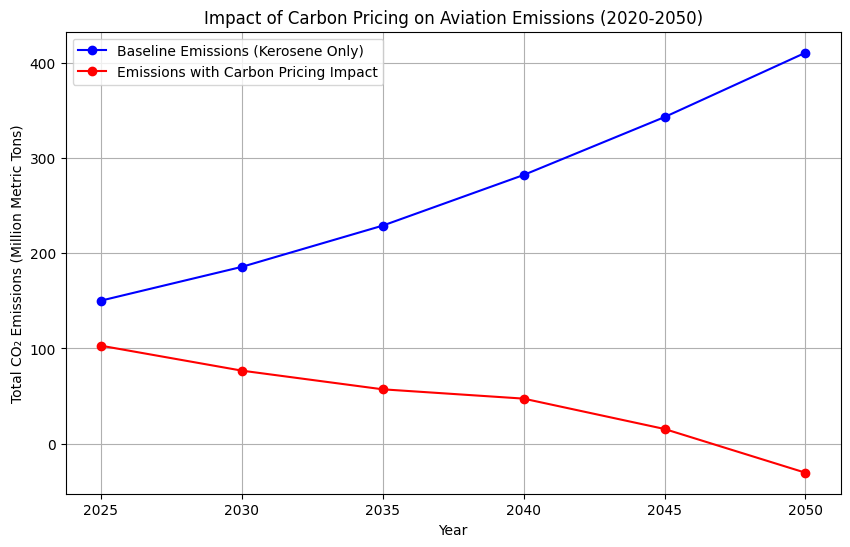

Total Baseline Emissions (2020-2050): 1601.33 million metric tons CO₂
Total Emissions with Carbon Pricing (2020-2050): 268.63 million metric tons CO₂
Reduction in Emissions with Carbon Pricing: 1332.70 million metric tons CO₂

Run time: 0:00:00.345380
Simulation finished


In [9]:
import agentpy as ap
import matplotlib.pyplot as plt

# Define your data
passengers = {
    2020: 728704096,  # passengers
    2025: 1015045526,
    2030: 1254965978,
    2035: 1547890737,
    2040: 1907473976,
    2045: 2318669627,
    2050: 2775767345
}

# Baseline price of kerosene in $/gallon (future prices)
kerosene_price = {
    2025: 2.723717,
    2030: 2.66691,
    2035: 2.770591,
    2040: 2.846833,
    2045: 2.91908,
    2050: 2.994338
}

# Carbon price in €/ton CO2
carbon_price_euro_per_ton = {
    2020: 25,
    2025: 80,
    2030: 146,
    2035: 194,
    2040: 221,
    2045: 260,
    2050: 300
}

# Conversion factors and constants
emission_factor_kerosene_per_km = 0.148  # kg CO₂ per passenger per km
distance_flown_km = 1000  # average distance flown per passenger in km
co2_emission_factor_per_gallon = 9.75  # kg CO₂ per gallon of kerosene
eur_to_usd = 1.1  # EUR to USD conversion rate

# Function to calculate adjusted kerosene price due to carbon pricing
def calculate_adjusted_kerosene_price(kerosene_price, carbon_price_euro, co2_emission_factor_per_gallon, eur_to_usd):
    carbon_price_usd_per_ton = carbon_price_euro * eur_to_usd
    carbon_price_usd_per_gallon = carbon_price_usd_per_ton / 1000 * co2_emission_factor_per_gallon
    return kerosene_price + carbon_price_usd_per_gallon

# Define the Aircraft agent
class Aircraft(ap.Agent):
    def setup(self):
        self.emission_factor_kerosene_per_km = emission_factor_kerosene_per_km
        self.distance_flown_km = distance_flown_km
    
    def calculate_emissions(self, passengers, kerosene_price, adjusted=False, carbon_price_euro=None):
        if adjusted and carbon_price_euro is not None:
            # Adjust kerosene price due to carbon pricing
            adjusted_price = calculate_adjusted_kerosene_price(
                kerosene_price, 
                carbon_price_euro, 
                co2_emission_factor_per_gallon, 
                eur_to_usd
            )
            price_ratio = adjusted_price / kerosene_price
            adjusted_passengers = passengers * (1 - (price_ratio - 1))
            emissions = adjusted_passengers * self.emission_factor_kerosene_per_km * self.distance_flown_km
        else:
            # Baseline emissions
            emissions = passengers * self.emission_factor_kerosene_per_km * self.distance_flown_km
        return emissions / 10**9  # Convert to million metric tons

# Define the model
class SAFModel(ap.Model):
    def setup(self):
        # Create a single aircraft agent
        self.aircraft = Aircraft(self)

        # Store emissions data
        self.emissions_baseline = {}
        self.emissions_adjusted = {}

        # Extract years for simulation steps
        self.years = list(passengers.keys())

    def step(self):
        # Ensure the step index is within bounds
        if self.t < len(self.years):
            # Get the current year based on the step index
            year = self.years[self.t]

            # Calculate baseline emissions (no carbon price impact)
            baseline_emissions = self.aircraft.calculate_emissions(
                passengers[year], 
                kerosene_price.get(year, 0), 
                adjusted=False
            )
            self.emissions_baseline[year] = baseline_emissions

            # Calculate adjusted emissions (with carbon price impact)
            if year in carbon_price_euro_per_ton and year in kerosene_price:
                adjusted_emissions = self.aircraft.calculate_emissions(
                    passengers[year], 
                    kerosene_price[year], 
                    adjusted=True, 
                    carbon_price_euro=carbon_price_euro_per_ton[year]
                )
                self.emissions_adjusted[year] = adjusted_emissions

    def end(self):
        # At the end of the simulation, plot the results
        years = list(self.emissions_baseline.keys())
        baseline_emissions = [self.emissions_baseline[year] for year in years]
        adjusted_emissions = [self.emissions_adjusted.get(year, 0) for year in years]
        
        plt.figure(figsize=(10, 6))
        plt.plot(years, baseline_emissions, 'b-o', label='Baseline Emissions (Kerosene Only)')
        plt.plot(years, adjusted_emissions, 'r-o', label='Emissions with Carbon Pricing Impact')
        
        plt.title('Impact of Carbon Pricing on Aviation Emissions (2020-2050)')
        plt.xlabel('Year')
        plt.ylabel('Total CO₂ Emissions (Million Metric Tons)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Print total emissions for baseline and adjusted scenarios
        total_baseline_emissions = sum(baseline_emissions)
        total_adjusted_emissions = sum(adjusted_emissions)
        
        print(f"Total Baseline Emissions (2020-2050): {total_baseline_emissions:.2f} million metric tons CO₂")
        print(f"Total Emissions with Carbon Pricing (2020-2050): {total_adjusted_emissions:.2f} million metric tons CO₂")
        print(f"Reduction in Emissions with Carbon Pricing: {(total_baseline_emissions - total_adjusted_emissions):.2f} million metric tons CO₂")

# Simulation parameters
parameters = {
    'steps': len(passengers)  # Number of years in the simulation
}

# Create and run the model
model = SAFModel(parameters)
results = model.run()


## Scenario 3: Modal Shift (Lower demand - SSP3)

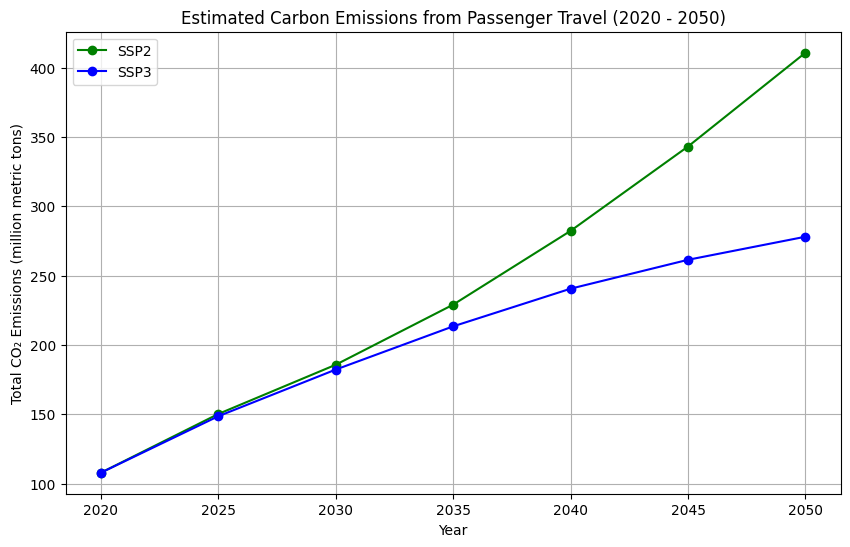

In [12]:
import matplotlib.pyplot as plt

# Given data
ssp3_passengers = {
    2020: 728704096,
    2025: 1004030293,
    2030: 1231434624,
    2035: 1442109057,
    2040: 1625645185,
    2045: 1766509660,
    2050: 1878970069
}

# Define the emission factor 
kilometers_flown = 1000  # average distance flown per passenger in km
emission_factor = 0.148  # kg CO₂ per passenger per km for Airbus A380 fleet

# Calculate the total emissions for each year (in kg CO2)
emissions_kg = {year: ssp3_passengers[year] * emission_factor * kilometers_flown for year in ssp3_passengers}

# Convert emissions to million metric tons of CO2
emissions_million_metric_tons = {year: emissions_kg[year] / 1e9 for year in emissions_kg}

# Plot the results
years = list(emissions_million_metric_tons.keys())
total_emissions_ssp3 = list(emissions_million_metric_tons.values())

plt.figure(figsize=(10, 6))
plt.plot(years, total_emissions, marker='o', linestyle='-', color='g', label='Baseline SSP2')
plt.plot(years, total_emissions_ssp3, marker='o', linestyle='-', color='b', label='SSP3')
plt.title('Estimated Carbon Emissions from Passenger Travel (2020 - 2050)')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions (million metric tons)')
plt.grid(True)
plt.show()



## Scenario 3: Modal Shift (Higher demand - SS1, 4 and 5)

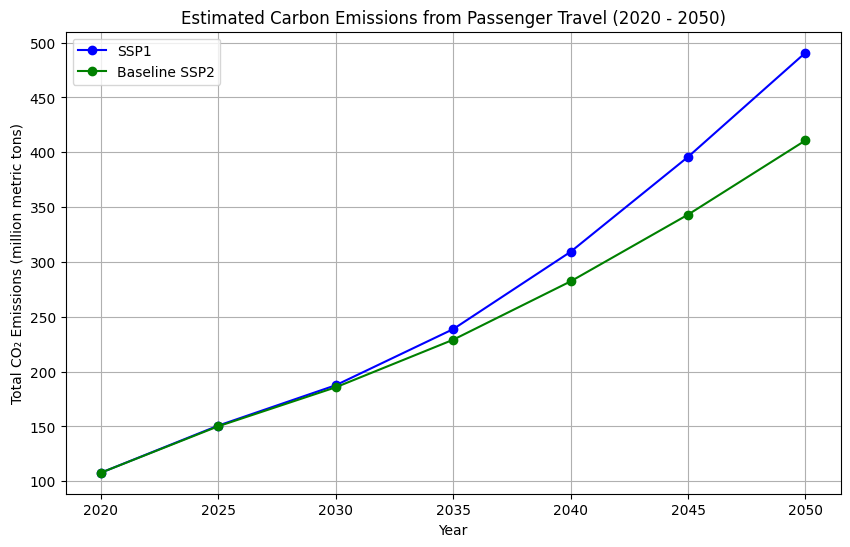

In [66]:
import matplotlib.pyplot as plt

# Given data
ssp1_passengers = {
    2020: 728704096,
    2025: 1019091214,
    2030: 1267720208,
    2035: 1613224871,
    2040: 2089613255,
    2045: 2674268501,
    2050: 3316209312
}

# Define the emission factor 
kilometers_flown = 1000  # average distance flown per passenger in km
emission_factor = 0.148  # kg CO₂ per passenger per km for Airbus A380 fleet

# Calculate the total emissions for each year (in kg CO2)
emissions_kg = {year: ssp1_passengers[year] * emission_factor * kilometers_flown for year in ssp1_passengers}

# Convert emissions to million metric tons of CO2
emissions_million_metric_tons = {year: emissions_kg[year] / 1e9 for year in emissions_kg}

# Plot the results
years = list(emissions_million_metric_tons.keys())
total_emissions_ssp1 = list(emissions_million_metric_tons.values())

plt.figure(figsize=(10, 6))
plt.plot(years, total_emissions_ssp1, marker='o', linestyle='-', color='b', label='SSP1')
plt.plot(years, total_emissions, marker='o', linestyle='-', color='g', label='Baseline SSP2')
plt.title('Estimated Carbon Emissions from Passenger Travel (2020 - 2050)')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions (million metric tons)')
plt.grid(True)
plt.show()



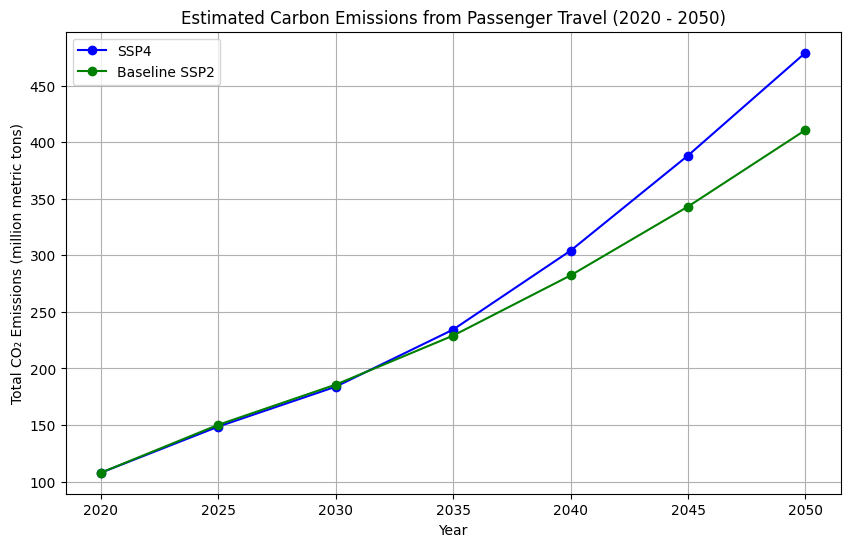

In [17]:
import matplotlib.pyplot as plt

# Given data
ssp4_passengers = {
    2020: 728704096,
    2025: 1004369321,
    2030: 1242596999,
    2035: 1583837931,
    2040: 2055351138,
    2045: 2623657054,
    2050: 3237704170
}

# Define the emission factor 
kilometers_flown = 1000  # average distance flown per passenger in km
emission_factor = 0.148  # kg CO₂ per passenger per km for Airbus A380 fleet

# Calculate the total emissions for each year (in kg CO2)
emissions_kg = {year: ssp4_passengers[year] * emission_factor * kilometers_flown for year in ssp4_passengers}

# Convert emissions to million metric tons of CO2
emissions_million_metric_tons = {year: emissions_kg[year] / 1e9 for year in emissions_kg}

# Plot the results
years = list(emissions_million_metric_tons.keys())
total_emissions_ssp4 = list(emissions_million_metric_tons.values())

plt.figure(figsize=(10, 6))
plt.plot(years, total_emissions_ssp4, marker='o', linestyle='-', color='b', label='SSP4')
plt.plot(years, total_emissions, marker='o', linestyle='-', color='g', label='Baseline SSP2')
plt.title('Estimated Carbon Emissions from Passenger Travel (2020 - 2050)')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions (million metric tons)')
plt.grid(True)
plt.show()



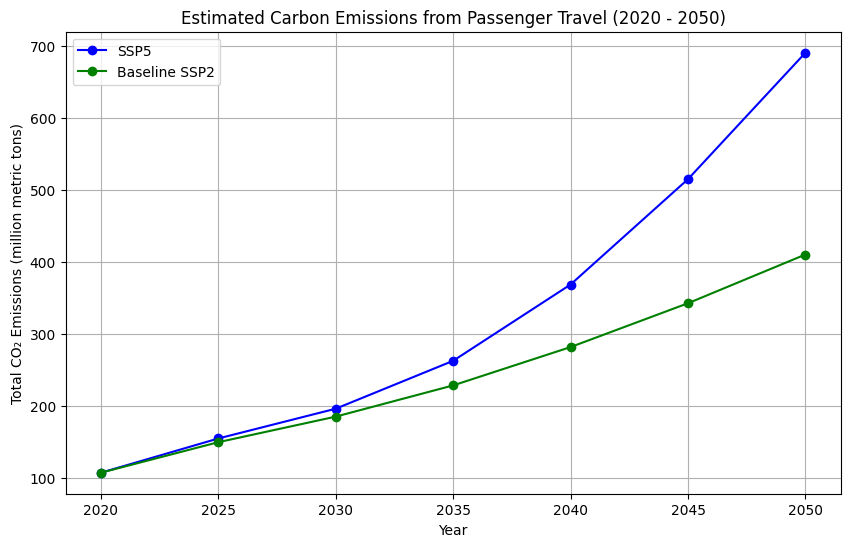

In [18]:
import matplotlib.pyplot as plt

# Given data
ssp5_passengers = {
    2020: 728704096,
    2025: 1049966723,
    2030: 1329231915,
    2035: 1778619654,
    2040: 2494257052,
    2045: 3482652811,
    2050: 4668712756
}

# Define the emission factor 
kilometers_flown = 1000  # average distance flown per passenger in km
emission_factor = 0.148  # kg CO₂ per passenger per km for Airbus A380 fleet

# Calculate the total emissions for each year (in kg CO2)
emissions_kg = {year: ssp5_passengers[year] * emission_factor * kilometers_flown for year in ssp5_passengers}

# Convert emissions to million metric tons of CO2
emissions_million_metric_tons = {year: emissions_kg[year] / 1e9 for year in emissions_kg}

# Plot the results
years = list(emissions_million_metric_tons.keys())
total_emissions_ssp5 = list(emissions_million_metric_tons.values())

plt.figure(figsize=(10, 6))
plt.plot(years, total_emissions_ssp5, marker='o', linestyle='-', color='b', label='SSP5')
plt.plot(years, total_emissions, marker='o', linestyle='-', color='g', label='Baseline SSP2')
plt.title('Estimated Carbon Emissions from Passenger Travel (2020 - 2050)')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions (million metric tons)')
plt.grid(True)
plt.show()

